In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/house price (train).csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


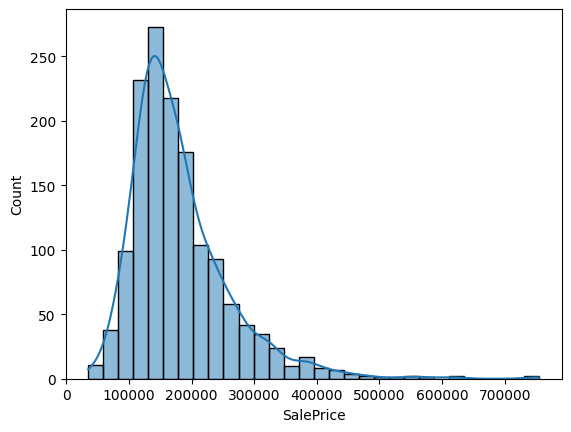

In [ ]:
sns.histplot(df["SalePrice"] , bins=30 , kde=True)
plt.show()

Data is positively skewed so we first make it normal

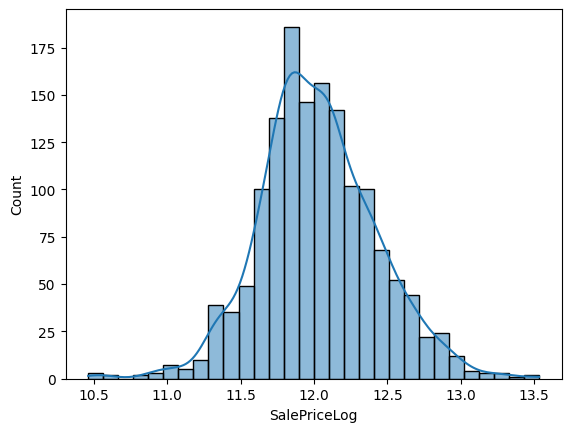

In [ ]:
df["SalePriceLog"] = np.log1p(df["SalePrice"])
sns.histplot(df["SalePriceLog"] , bins=30 , kde=True)
plt.show()

In [ ]:
# df.drop(["SalePriceLog"],axis=1,inplace=True)
correlation = df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
correlation.head(7)

,SalePrice
SalePrice,1.000000
SalePriceLog,0.948374
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581


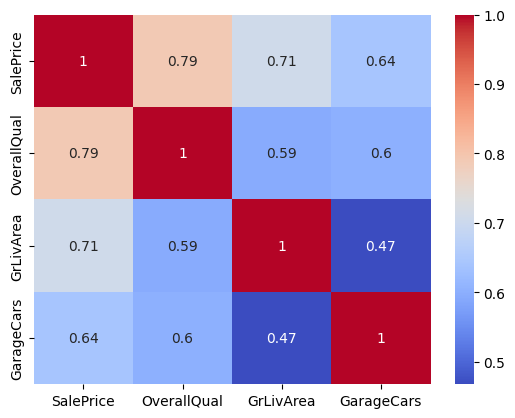

In [ ]:
sns.heatmap(df[["SalePrice","OverallQual","GrLivArea","GarageCars"]].corr(numeric_only=True) , annot=True ,cmap="coolwarm")
plt.show()

Model Building

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Datasets/house price (train).csv")


# Dropping columns having 50% or more null values
train_df.drop(["Id","Alley","MasVnrType","PoolQC","Fence","MiscFeature"],axis=1,inplace=True)

# Making list of numeric and categorical features
numeric_features = train_df.select_dtypes(include=["int64" , "float64"]).columns.tolist()
categorical_features = train_df.select_dtypes(include=["object"]).columns.tolist()

# removing y-column or column to be predit from numeric feature
numeric_features.remove("SalePrice")

# X and Y variable
X = train_df.drop(["SalePrice"] , axis=1)
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
y = train_df["SalePrice"]

# train-test split
x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)


In [ ]:
# pipeline for numeric features
numeric_transfomer = Pipeline([
    ("imputer" , SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

# pipeline for categorical features
categorical_transformer = Pipeline([
    ("imputer" , SimpleImputer(strategy="most_frequent")),
    ("onehot" , OneHotEncoder(handle_unknown="ignore"))
])


preprocessing = ColumnTransformer([
    ("numeric" , numeric_transfomer , numeric_features),
    ("categorical" , categorical_transformer , categorical_features)
])

In [ ]:
# Modelinitialization
lr = Pipeline([
    ("preprocessing" , preprocessing),
    ("model" , LinearRegression())
])
# fitting model
lr.fit(x_train , y_train)

# predicting
y_pred_lr = lr.predict(x_test)

# reverse log or exponent
actual_lr_predict = np.expm1(y_pred_lr)
actual_lr_test = np.expm1(y_test)

# result
results = {
    "mae": round(mean_absolute_error(actual_lr_test, actual_lr_predict), 3),
    "rmse": np.sqrt(mean_squared_error(actual_lr_test, actual_lr_predict)),
    "r2": round(r2_score(actual_lr_test, actual_lr_predict), 3)
}
print(results)

{'mae': 15065.306, 'rmse': np.float64(22966.413143352387), 'r2': 0.931}


In [ ]:
rf = Pipeline([
    ("preprocessing" , preprocessing),
    ("model" , RandomForestRegressor())
])
rf.fit(x_train , y_train)
y_pred_rf = rf.predict(x_test)
actual_rf_predict = np.expm1(y_pred_rf)
actual_rf_test = np.expm1(y_test)

results = {
    "mae": round(mean_absolute_error(actual_rf_test, actual_rf_predict), 3),
    "rmse": np.sqrt(mean_squared_error(actual_rf_test, actual_rf_predict)),
    "r2": round(r2_score(actual_rf_test, actual_rf_predict), 3)
}
results

{'mae': 17644.433, 'rmse': np.float64(29943.036251955597), 'r2': 0.883}

In [ ]:
xgb = Pipeline([
    ("preprocessing" , preprocessing),
    ("model" , XGBRegressor())
])
xgb.fit(x_train , y_train)
y_pred_xgb = xgb.predict(x_test)
actual_xgb_predict = np.expm1(y_pred_xgb)
actual_xgb_test = np.expm1(y_test)

results = {
    "mae": round(mean_absolute_error(actual_xgb_test, actual_xgb_predict), 3),
    "rmse": np.sqrt(mean_squared_error(actual_xgb_test, actual_xgb_predict)),
    "r2": round(r2_score(actual_xgb_test, actual_xgb_predict), 3)
}
results

{'mae': 16247.228, 'rmse': np.float64(25524.723273167252), 'r2': 0.915}

# Since the Linear regression is doing the best job so applying test data on Linear Regression

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Datasets/house price test.csv")

test_ids = test_df["Id"]

# Dropping columns having 50% or more null values
test_df.drop(["Id","Alley","MasVnrType","PoolQC","Fence","MiscFeature"],axis=1,inplace=True)

# Making list of numeric and categorical features
numeric_features = train_df.select_dtypes(include=["int64" , "float64"]).columns.tolist()
categorical_features = train_df.select_dtypes(include=["object"]).columns.tolist()

test_predict = lr.predict(test_df)
actual_predict = np.expm1(test_predict)
test_result = pd.DataFrame(actual_predict,columns=["Price"])

test_result = pd.concat([test_ids,test_result] , axis=1)
test_result.to_csv("test_result.csv" , index=False)